In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.frame_loading import load_frames
import os


In [8]:
# Load 5 random LT frames for blob detection
frames_dir = "../Data/frames/LT"
frame_paths = load_frames(frames_dir, prefix="LT_", limit=5, randomize=True)


[INFO] Loaded 5 frame(s):
   → LT_0430.jpg
   → LT_0074.jpg
   → LT_0162.jpg
   → LT_0391.jpg
   → LT_0538.jpg


In [ ]:
def detect_blobs(image, threshold_val=60, min_area=20, show_mask=False, roi_mask=None):
    """
    Detect dark blobs in a given image, with optional ROI masking.

    Args:
        image (np.ndarray): BGR image
        threshold_val (int): Threshold value to isolate dark pixels
        min_area (int): Minimum blob area to count as surfer
        show_mask (bool): If True, return binary mask
        roi_mask (np.ndarray): Optional binary mask to limit blob detection

    Returns:
        image_with_boxes (np.ndarray), count, (optional) mask
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, threshold_val, 255, cv2.THRESH_BINARY_INV)

    # Apply ROI mask if provided
    if roi_mask is not None:
        thresh = cv2.bitwise_and(thresh, thresh, mask=roi_mask)

    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    surfer_blobs = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Draw bounding boxes
    annotated = image.copy()
    for cnt in surfer_blobs:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(annotated, (x, y), (x + w, y + h), (0, 255, 0), 1)

    if show_mask:
        return annotated, len(surfer_blobs), thresh
    return annotated, len(surfer_blobs)

def create_roi_mask(image, crop_ratio=0.2):
    """
    Creates a binary mask for the top region of the image (e.g. ocean only).
    crop_ratio defines how much of the bottom of the image to exclude.

    Returns:
        np.ndarray: binary mask with beach excluded
    """
    mask = np.ones(image.shape[:2], dtype=np.uint8) * 255
    height = image.shape[0]
    mask[int(height * (1 - crop_ratio)):, :] = 0
    return mask

def visualize_blob_detection(img, roi, annotated_img, blob_mask, count, filename=""):
    """
    Creates a 3-panel visualization:
    1. ROI Overlay
    2. Binary Mask
    3. Final Detection with Bounding Boxes
    """
    # ROI overlay
    roi_colored = cv2.merge([roi, roi, roi])  # Convert to 3-channel
    overlay = cv2.addWeighted(img, 0.7, roi_colored, 0.3, 0)

    # Convert all images to RGB for plotting
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    annotated_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(overlay_rgb)
    plt.title("ROI Overlay")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(blob_mask, cmap='gray')
    plt.title("Thresholded Binary Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(annotated_rgb)
    plt.title(f"{filename} — Surfers Detected: {count}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


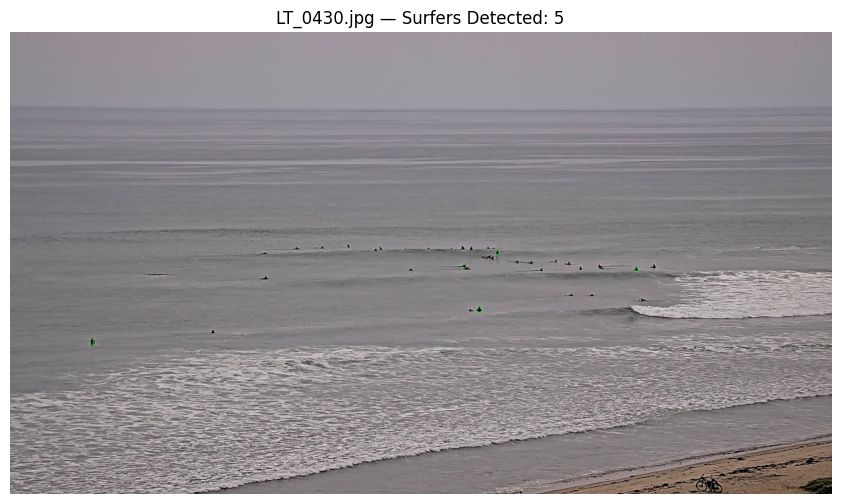

In [ ]:
img = cv2.imread(frame_paths[0])
roi = create_roi_mask(img, crop_ratio=0.2)

# Run blob detection with mask
annotated, count, mask = detect_blobs(img, roi_mask=roi, show_mask=True)

# Visualize all steps
visualize_blob_detection(img, roi, annotated, mask, count, os.path.basename(frame_paths[0]))

In [ ]:
# Visualize raw threshold mask for a single frame
sample = cv2.imread(frame_paths[0])
_, _, mask = detect_blobs(sample, show_mask=True)

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray')
plt.title("Binary Mask of Surfer Blobs")
plt.axis("off")
plt.show()
